# Tree Crown Segmentation 
using Drone Imagery (DJI P4 Multispectral) processed with Open Drone Map  

### import libraries

In [1]:
import os
import glob
import laspy
import numpy as np
import open3d as o3d
import random
import lazrs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required even if not directly used
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import pdal
import json
from rasterstats import zonal_stats
from skimage.measure import find_contours
from shapely.geometry import Polygon
import geopandas as gpd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### functions

#### 3d visualization

In [2]:



# -------- needs to be revised: coordinates are only for this specific example!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def visualize_3d(points):
    """
    Visualizes a 3D scatter plot of a point cloud using axonometric (orthographic) projection.

    Parameters:
        points (np.ndarray): A NumPy array of shape (N, 3) representing XYZ coordinates.
    """
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Set orthographic projection (no perspective distortion)
    ax.set_proj_type('ortho')

    scatter = ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        s=0.1,
        c=points[:, 2],
        cmap='viridis',
        vmin=170,
        vmax=200
    )

    ax.set_xlim(344875, 345095)
    ax.set_ylim(5756800, 5757000)
    ax.set_zlim(100, 260)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Decimated Point Cloud of all combined LAZ files")
    plt.show()


### Import Point Cloud

#### Read and Combine laz Files

In [3]:
# Path to the folder with the .laz files
path = r"C:\Users\nicolas\Documents\Work\CaptureAndRestore\Crown Segmentation Mock-Up\Prototype_Lutherstadt_Wittenberg\Mission_01_Multispectral_HQ\entwine_pointcloud\ept-data"

In [4]:
# Find all .laz files in the folder
laz_files = sorted(glob.glob(os.path.join(path, '**', '*.laz'), recursive=True))

print(f"Reading {len(laz_files)} files...")

# Read and combine all files
all_points = []

for laz_file in laz_files:
    #print(f"Reading: {laz_file}")
    las = laspy.read(laz_file)
    points = np.vstack((las.x, las.y, las.z)).T  # Combine X, Y, Z into a Nx3 array
    all_points.append(points)

# Combine all point arrays into one
combined_points = np.vstack(all_points)
print(f"Combined point cloud has {combined_points.shape[0]:,} points.")

Reading 328 files...
Combined point cloud has 12,322,116 points.


In [5]:
combined_points

array([[3.44883450e+05, 5.75691382e+06, 1.75060000e+02],
       [3.44885280e+05, 5.75691388e+06, 1.75070000e+02],
       [3.44886670e+05, 5.75691386e+06, 1.75200000e+02],
       ...,
       [3.44930347e+05, 5.75686755e+06, 1.94571000e+02],
       [3.44930181e+05, 5.75686738e+06, 1.94628000e+02],
       [3.44930245e+05, 5.75686737e+06, 1.94623000e+02]])

In [6]:
# raise StopIteration("Next cell takes 6min")

In [7]:
# visualize_3d(combined_points) ### only run when needed

#### Downsampling

In [8]:
# define sample size here
sample_size = 100_000

indices = np.random.choice(combined_points.shape[0], sample_size, replace=False)
points_decimated = combined_points[indices]


In [9]:
def visualize_3d(
    points,
    title="3D Point Cloud",
    box_size={"x": 200, "y": 200, "z": 100},
    azimuth=45,
    elevation=30,
    point_size=0.3  # <-- NEW: control point size here
):
    """
    Visualizes a 3D point cloud with transparent background, white gridlines,
    and customizable point size, color, and view angles.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(20, 15), facecolor='none')
    ax = fig.add_subplot(111, projection='3d', facecolor='none')
    ax.set_proj_type('ortho')

    # Scatter plot with customizable point size and full opacity
# Scatter plot with customizable point size and full opacity
    scatter = ax.scatter(
        points[:, 0], points[:, 1], points[:, 2],
        s=point_size,
        c=points[:, 2],
        cmap='viridis',
        alpha=1.0
    )


    # Center and set axis limits
    center_x = (points[:, 0].min() + points[:, 0].max()) / 2
    center_y = (points[:, 1].min() + points[:, 1].max()) / 2
    center_z = (points[:, 2].min() + points[:, 2].max()) / 2

    x_half = box_size["x"] / 2
    y_half = box_size["y"] / 2
    z_half = box_size["z"] / 2

    x_min, x_max = center_x - x_half, center_x + x_half
    y_min, y_max = center_y - y_half, center_y + y_half
    z_min, z_max = center_z - z_half, center_z + z_half

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    # 10-unit ticks
    ax.set_xticks(np.arange(np.floor(x_min / 10) * 10, np.ceil(x_max / 10) * 10 + 1, 10))
    ax.set_yticks(np.arange(np.floor(y_min / 10) * 10, np.ceil(y_max / 10) * 10 + 1, 10))
    ax.set_zticks(np.arange(np.floor(z_min / 10) * 10, np.ceil(z_max / 10) * 10 + 1, 10))

    ax.view_init(elev=elevation, azim=azimuth)

    # Hide X/Y tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("")

    # White ticks
    ax.tick_params(colors='gray')


    # Gray dotted gridlines
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo["grid"]['color'] = "gray"
        axis._axinfo["grid"]['linestyle'] = ":"  # dotted lines


    # Gray dotted gridlines
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo["grid"]['color'] = "gray"
        axis._axinfo["grid"]['linestyle'] = ":"  # dotted lines
        axis._axinfo["axisline"]["color"] = "gray"  # axis lines (spines) gray


    # Transparent pane backgrounds
    ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
    ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

    # Title in white
    ax.set_title(title, color='white')

    # Transparent canvas
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0)

    # Add colorbar for Z values
    cbar = fig.colorbar(scatter, ax=ax, pad=0.02, shrink=0.6, aspect=20)
    cbar.set_label("Z (Elevation)", color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(cbar.ax.get_yticklabels(), color='white')



    plt.show()


In [10]:
visualize_3d(
    points_decimated,
    title="Decimated Point Cloud",
    box_size={"x": 200, "y": 200, "z":100},
    azimuth=135  # Rotate counterclockwise (e.g., 180 for opposite side)
)


KeyboardInterrupt: 

In [ ]:

# -------- needs to be revised: coordinates are only for this specific example !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Get min and max values
x_min, x_max = points_decimated[:, 0].min(), points_decimated[:, 0].max()
y_min, y_max = points_decimated[:, 1].min(), points_decimated[:, 1].max()
z_min, z_max = points_decimated[:, 2].min(), points_decimated[:, 2].max()

print(f"X limits: ({x_min:.2f}, {x_max:.2f})")
print(f"Y limits: ({y_min:.2f}, {y_max:.2f})")
print(f"Z limits: ({z_min:.2f}, {z_max:.2f})")


X limits: (344838.79, 345036.77)
Y limits: (5756810.74, 5756993.44)
Z limits: (170.93, 235.75)


#### delete z-axis outliers

In [ ]:
# Filter out points with Z > 200m above sea level
points_filtered = points_decimated[points_decimated[:, 2] <= 200]
print(f"Points before filtering: {points_decimated.shape[0]:,}")
print(f"Points after filtering: {points_filtered.shape[0]:,}")

Points before filtering: 100,000
Points after filtering: 98,166


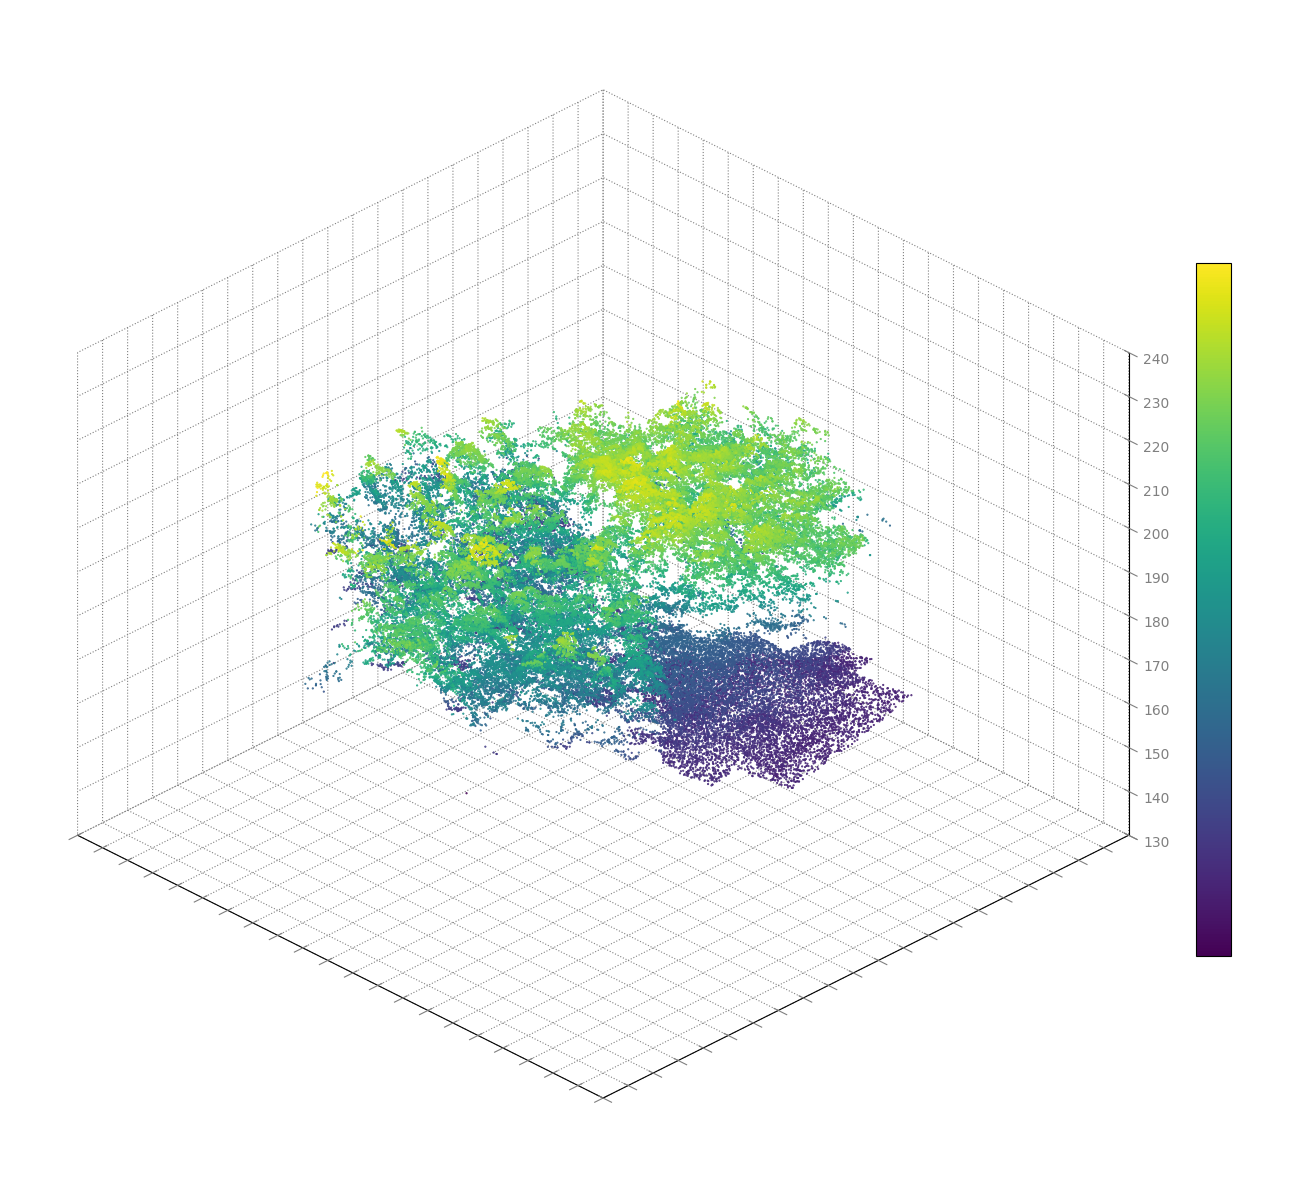

In [ ]:
visualize_3d(
    points_filtered,
    title="Decimated Point Cloud // Filtered",
    box_size={"x": 200, "y": 200, "z":100},
    azimuth=135  # Rotate counterclockwise (e.g., 180 for opposite side)
)

### generate dtm

ground points (replace filters.smrf with filters.mcc later!!!!)

In [ ]:


# --- Step 1: Save filtered points as LAS ---
from laspy import LasData, LasHeader

def save_las_from_numpy(filename, points):
    header = LasHeader(point_format=3, version="1.2")
    las = LasData(header)
    las.x = points[:, 0]
    las.y = points[:, 1]
    las.z = points[:, 2]
    las.write(filename)

input_path = "temp_filtered.las"
output_path = "ground_classified.las"

save_las_from_numpy(input_path, points_filtered)

# --- Step 2: Create PDAL pipeline with MCC filter ---
pipeline_json = {
    "pipeline": [
        input_path,
        {
            "type": "filters.smrf",
            "slope": 0.1,
            "window": 16.0,
            "threshold": 0.35,
            "scalar": 1.0
        },
        {
            "type": "filters.range",
            "limits": "Classification[2:2],Z[0:176]"  # Keep only ground points under 176m <------- this can be improved
        },
        output_path
    ]
}


pipeline = pdal.Pipeline(json.dumps(pipeline_json))
pipeline.execute()

# --- Step 3: Load classified LAS ---
las = laspy.read(output_path)


# Load your data
x = las.x
y = las.y
z = las.z
classification = las.classification

# Split points by classification
ground_mask = classification == 2
non_ground_mask = ~ground_mask

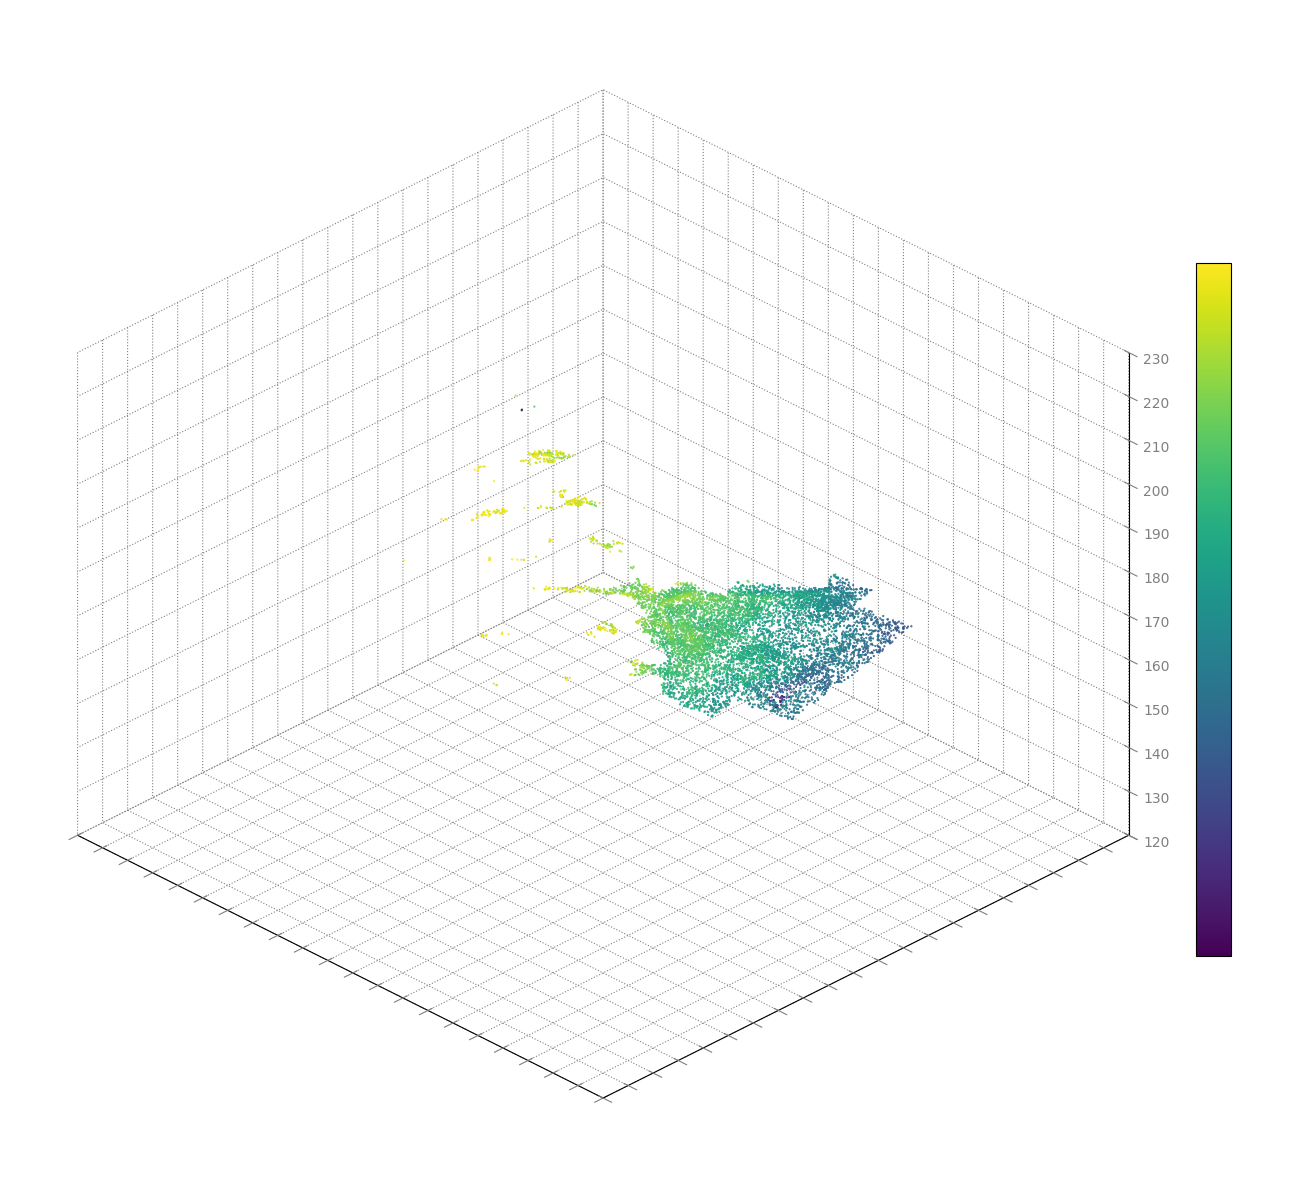

In [ ]:

ground_points = np.vstack((las.x[ground_mask], las.y[ground_mask], las.z[ground_mask])).T

visualize_3d(
    ground_points,
    title="Ground Points",
    box_size={"x": 200, "y": 200, "z":100},
    azimuth=135  # Rotate counterclockwise (e.g., 180 for opposite side)
)

#### delete z outliers at ground level

In [ ]:
# Compute percentile limits
z = points_filtered[:, 2]
z_min, z_max = np.percentile(z, [1, 99])  # Keep middle 98% of points

# Filter based on those thresholds
mask = (z >= z_min) & (z <= z_max)
points_no_outliers = points_filtered[mask]

print(f"Original points: {points_filtered.shape[0]:,}")
print(f"After Z outlier removal: {points_no_outliers.shape[0]:,}")


Original points: 98,166
After Z outlier removal: 96,224


#### create mesh

In [ ]:
# from pykrige.ok import OrdinaryKriging
# import numpy as np

# # Step 1: Extract ground points
# ground_mask = (las.classification == 2)
# ground_points = np.vstack((las.x[ground_mask], las.y[ground_mask], las.z[ground_mask])).T

# # Step 2: Use full cloud extent, not just ground points
# xmin, xmax = las.x.min(), las.x.max()
# ymin, ymax = las.y.min(), las.y.max()

# grid_res = 1.0  # meter resolution
# grid_x = np.arange(xmin, xmax, grid_res)
# grid_y = np.arange(ymin, ymax, grid_res)

# # Step 3: Fit Kriging model with ground points
# OK = OrdinaryKriging(
#     ground_points[:, 0],
#     ground_points[:, 1],
#     ground_points[:, 2],
#     variogram_model='linear',
#     verbose=False,
#     enable_plotting=False
# )

# # Step 4: Interpolate over full grid extent
# z_kriged, ss = OK.execute('grid', grid_x, grid_y)


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 10))
# plt.imshow(z_kriged, extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
#            origin='lower', cmap='terrain')
# plt.colorbar(label='Elevation (m)')
# plt.title("Digital Terrain Model (DTM) - Kriging")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.show()


In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np

# X, Y = np.meshgrid(grid_x, grid_y)

# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Plot DTM
# ax.plot_surface(X, Y, z_kriged, cmap='terrain', linewidth=0, antialiased=True)

# # Set a less extreme aspect ratio: (X, Y, Z)
# ax.set_box_aspect([1, 1, 0.2])  # Z is 5x flatter than X/Y

# # Labels and title
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Elevation (Z)")
# ax.set_title("3D Digital Terrain Model (DTM) - Kriging")

# plt.show()


In [ ]:
# # Filter ground points only (classification == 2)
# ground_mask = (las.classification == 2)
# ground_points = np.vstack((las.x[ground_mask], las.y[ground_mask], las.z[ground_mask])).T

In [ ]:
# # Set up grid extent and resolution
# xmin, xmax = ground_points[:, 0].min(), ground_points[:, 0].max()
# ymin, ymax = ground_points[:, 1].min(), ground_points[:, 1].max()
# grid_res = 1.0  # meters

# grid_x = np.arange(xmin, xmax, grid_res)
# grid_y = np.arange(ymin, ymax, grid_res)

# # Prepare Kriging model (k=40 neighbors implied in semivariogram model)
# OK = OrdinaryKriging(
#     ground_points[:, 0],
#     ground_points[:, 1],
#     ground_points[:, 2],
#     variogram_model='linear',  # can also try 'spherical', 'gaussian'
#     verbose=False,
#     enable_plotting=False
# )

# z_kriged, ss = OK.execute('grid', grid_x, grid_y)


In [ ]:


# # Re-create meshgrid for plotting
# grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# # Create the figure and 3D plot
# fig = plt.figure(figsize=(12, 9))
# ax = fig.add_subplot(111, projection='3d')

# # Surface plot
# surf = ax.plot_surface(
#     grid_xx, grid_yy, z_kriged,
#     # cmap='terrain',
#     linewidth=0,
#     antialiased=True,
#     alpha=0.9,
#     cmap='viridis', 
#     vmin=170,
#     vmax=200
# )

# # Apply fixed axis limits
# ax.set_xlim(344889, 345095)
# ax.set_ylim(5756777, 5756992)
# ax.set_zlim(170, 200)

# # Labels
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Elevation (Z)")
# plt.title("Digital Terrain Model (DTM) - 3D View (Kriging)")

# # Optional: Add colorbar
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Elevation (m)')

# plt.show()


In [ ]:
import rasterio

dsm_path = r"C:\Users\nicolas\Documents\Work\CaptureAndRestore\Crown Segmentation Mock-Up\Prototype_Lutherstadt_Wittenberg\Mission_01_Multispectral_HQ\odm_dem\dsm.tif"


# Load DSM and extract spatial info
with rasterio.open(dsm_path) as src:
    dsm_bounds = src.bounds
    dsm_transform = src.transform
    dsm_crs = src.crs
    dsm_res = src.res  # (pixel width, pixel height)
    dsm_shape = src.shape  # (rows, cols)

print(f"DSM resolution: {dsm_res}")
print(f"DSM shape: {dsm_shape}")


DSM resolution: (0.03427435489535005, 0.034274354895339657)
DSM shape: (5191, 5659)


In [ ]:
import numpy as np

# Create grid using DSM resolution and shape
grid_x = np.arange(dsm_bounds.left, dsm_bounds.right, dsm_res[0])
grid_y = np.arange(dsm_bounds.bottom, dsm_bounds.top, dsm_res[1])

# Reverse Y to make it bottom-to-top (as expected by np.meshgrid)
grid_y = grid_y[::-1]


In [ ]:
from pykrige.ok import OrdinaryKriging

# Use previously extracted ground_points (X, Y, Z)
OK = OrdinaryKriging(
    ground_points[:, 0],
    ground_points[:, 1],
    ground_points[:, 2],
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)

z_kriged, ss = OK.execute('grid', grid_x, grid_y)


MemoryError: Unable to allocate 1.81 TiB for an array with shape (29375869, 8455) and data type float64

#### Save Digital terrain Model (DTM)

In [ ]:


# Define transform (top-left origin, pixel size)
transform = from_origin(grid_x[0], grid_y[-1] + (grid_y[1] - grid_y[0]),  # top-left corner
                        grid_x[1] - grid_x[0], grid_y[1] - grid_y[0])      # pixel size

# Save GeoTIFF
with rasterio.open(
    'dtm_kriging.tif',
    'w',
    driver='GTiff',
    height=z_kriged.shape[0],
    width=z_kriged.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:32633',  # Change to match your coordinate system ---->> 32633
    transform=transform
) as dst:
    dst.write(z_kriged.astype('float32'), 1)

print("DTM saved as dtm_kriging.tif")


DTM saved as dtm_kriging.tif


### Generate Canopy Height Model (CHM)

#### load dsm

In [ ]:
import rasterio

# Load DSM GeoTIFF
dsm_path = r"C:\Users\nicolas\Documents\Work\CaptureAndRestore\Crown Segmentation Mock-Up\Prototype_Lutherstadt_Wittenberg\Mission_01_Multispectral_HQ\odm_dem\dsm.tif"

with rasterio.open(dsm_path) as src:
    dsm_data = src.read(1)
    transform = src.transform


In [ ]:
import numpy as np

# Get resolution and origin from transform
cols, rows = dsm_data.shape[1], dsm_data.shape[0]
x_coords = np.arange(cols) * transform.a + transform.c
y_coords = np.arange(rows) * transform.e + transform.f

# Create meshgrid for plotting
X, Y = np.meshgrid(x_coords, y_coords)
Z = dsm_data


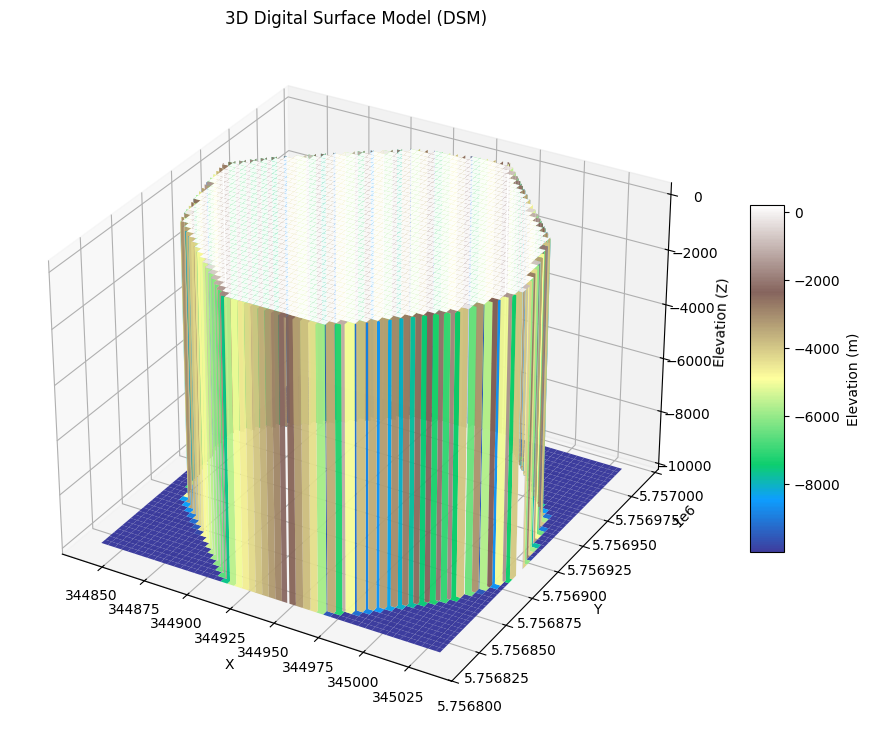

In [ ]:


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X, Y, Z,
    cmap='terrain',
    linewidth=0,
    antialiased=True,
    alpha=0.95
)


ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation (Z)")
ax.set_title("3D Digital Surface Model (DSM)")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Elevation (m)')
plt.show()


In [ ]:
import rioxarray

dsm = rioxarray.open_rasterio(dsm_path, masked=True).squeeze()
dtm = rioxarray.open_rasterio("dtm_kriging.tif", masked=True).squeeze()


Apply Median Filter to DTM

In [ ]:

from scipy.ndimage import median_filter

# Apply 3x3 median filter to smooth terrain
dtm_filtered = dtm.copy()
dtm_filtered.data = median_filter(dtm.data, size=3)


Decrease DSM Resolution (aggregate

In [ ]:
# Aggregate DSM by a factor of 5 using mean
dsm_coarse = dsm.coarsen(x=5, y=5, boundary='trim').mean()


Resample DTM to DSM resolution

In [ ]:
# Resample DTM to match DSM's coarser resolution
dtm_resampled = dtm_filtered.rio.reproject_match(dsm_coarse)


In [ ]:
assert dsm_coarse.rio.shape == dtm_resampled.rio.shape, "Mismatch in raster shapes"


Subtracting DSM from DTM for generating CHM

In [ ]:
# Subtract DTM from DSM to get CHM
chm = dsm_coarse - dtm_resampled


C:\Users\nicolas\AppData\Local\Temp\ipykernel_32676\29552719.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\nicolas\anaconda3\envs\crown_segmentation_drone\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


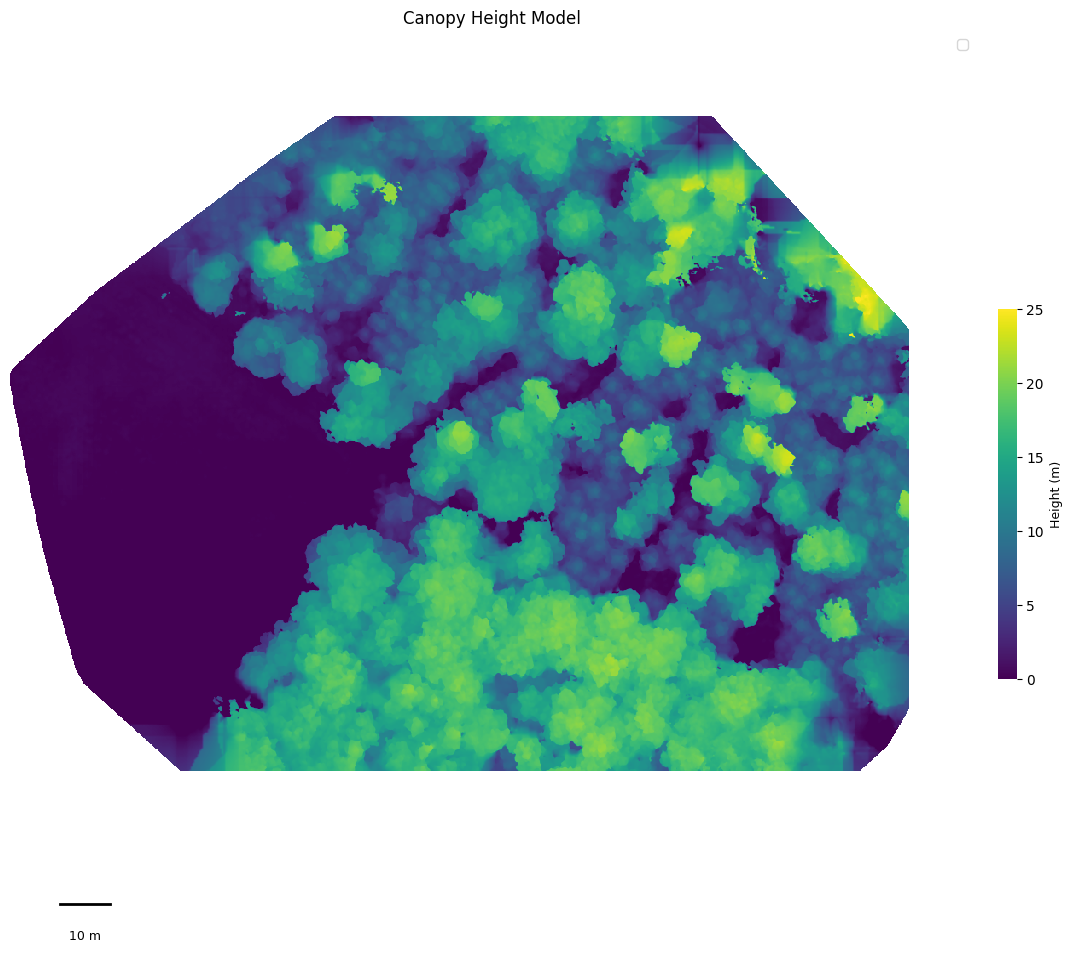

In [ ]:
plt.figure(figsize=(15, 12))
ax = plt.gca()

# Plot CHM in grayscale without colorbar
im = chm.plot(
    ax=ax,
    cmap='viridis',        
    vmin=0, vmax=25,
    add_colorbar=False
)

# Add grayscale colorbar manually
cbar = ax.figure.colorbar(
    im, ax=ax,
    orientation='vertical',
    shrink=0.4,
    aspect=20,
    pad=0.02,
    extend='neither'
)
cbar.set_label('Height (m)', fontsize=9)

# Remove colorbar frame
for spine in cbar.ax.spines.values():
    spine.set_visible(False)



# Remove axes and frame
ax.set_axis_off()
plt.title("Canopy Height Model")
plt.legend()

# Add 10m black scale bar
x0 = chm.x.min() + 10
y0 = chm.y.min() + 10
x1 = x0 + 10
ax.plot([x0, x1], [y0, y0], color='black', linewidth=2)
ax.text((x0 + x1) / 2, y0 - 5, '10 m', color='black',
        ha='center', va='top', fontsize=9)

plt.show()


#### Save Canopy Height Model (CHM)

In [ ]:
# Ensure CHM has CRS and transform info
chm.rio.to_raster("chm.tif")
print("CHM saved as chm.tif")

CHM saved as chm.tif


### Crown Segmentation

In [ ]:
# Your function: winFun = lin(x) = x * y + 0.6
def winfun(height, y=0.05):
    return height * y + 0.6

#### Detect local maxima (tree tops)

In [ ]:
from skimage.feature import peak_local_max
from skimage.morphology import disk
import numpy as np
import matplotlib.pyplot as plt

# Convert CHM to numpy array
chm_data = chm.data

# Mask CHM below min height
min_height = 5
chm_masked = np.where(chm_data >= min_height, chm_data, 0)

# Create variable window size per pixel based on height
window_radii = winfun(chm_masked, y=0.05)  # your window size function

# Try a larger window: e.g., 6–12 pixels (~meters)
fixed_window = 12  # or test 12, 15, etc. !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Can this be automated???? dynamically scale with height (like vwf)

coordinates = peak_local_max(
    chm_masked,
    min_distance=fixed_window,
    threshold_abs=min_height,
    exclude_border=False
)



#### Plot CHM and tree tops (like plot(chm); plot(ttops) in R)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

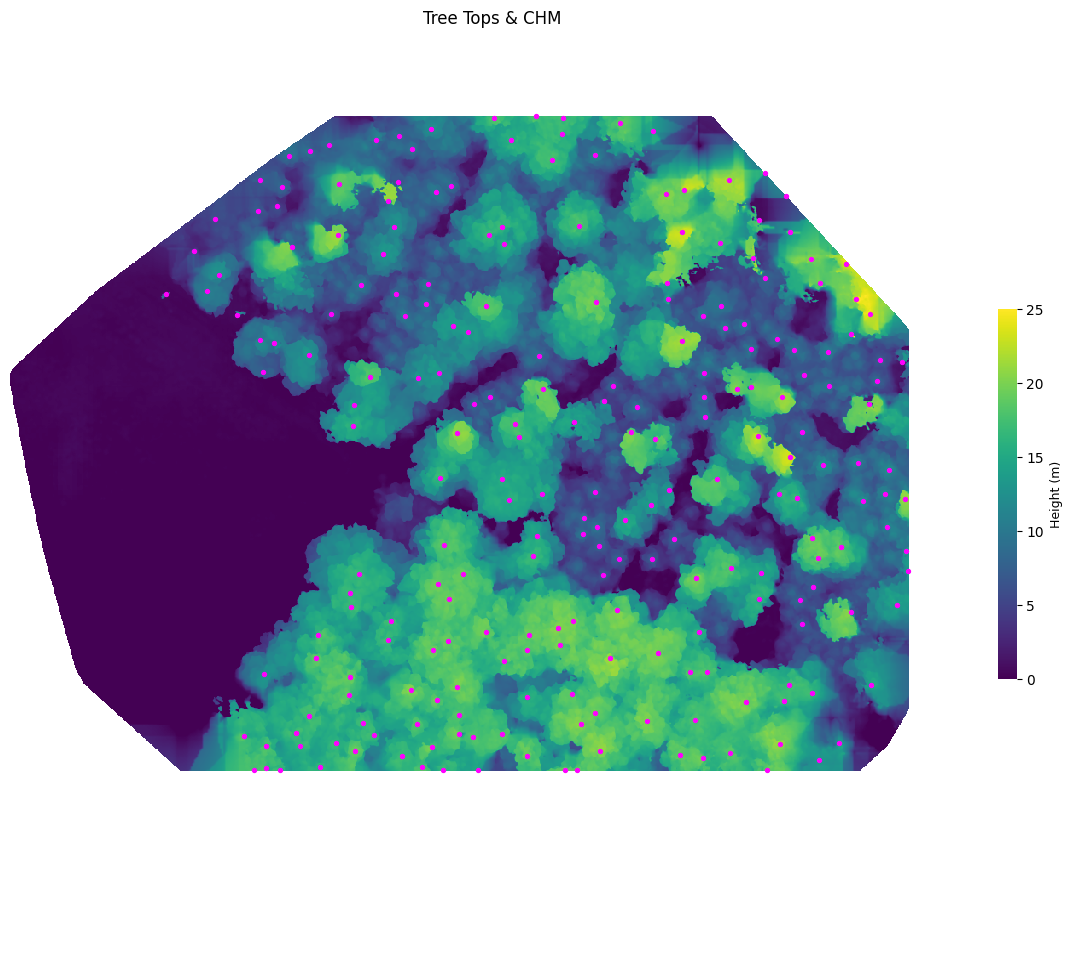

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
plt.figure(figsize=(15, 12))
ax = plt.gca()

# Plot CHM
im = chm.plot(
    ax=ax,
    cmap='viridis',
    vmin=0, vmax=25,
    add_colorbar=False
)

# Add colorbar manually
cbar = ax.figure.colorbar(
    im, ax=ax,
    orientation='vertical',
    shrink=0.4,
    aspect=20,
    pad=0.02,
    extend='neither'
)
cbar.set_label('Height (m)', fontsize=9)

# Remove colorbar frame
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Use coordinates[:, 0] as row indices and coordinates[:, 1] as col indices
rows = coordinates[:, 0].astype(int)
cols = coordinates[:, 1].astype(int)

# Use CHM's x and y coordinates directly
tree_x = chm.x[cols].values
tree_y = chm.y[rows].values

# Plot tree tops
plt.scatter(tree_x, tree_y, color='magenta', s=8, label='Tree Tops')

# Final map styling
ax.set_axis_off()
plt.title("Tree Tops & CHM")
plt.legend


#### Generate Marker Image (Tree Tops)

In [ ]:
from skimage.segmentation import watershed
from scipy import ndimage

# Create markers array same shape as CHM
markers = np.zeros_like(chm_data, dtype=np.int32)

# Label each tree top with a unique integer
for i, (row, col) in enumerate(coordinates, start=1):
    markers[row, col] = i


#### Apply Watershed Segmentation

In [ ]:
# Invert CHM so that high areas become basins (CHM is a height surface)
chm_inverted = -chm_data

# Run watershed segmentation
crown_segments = watershed(
    chm_inverted,
    markers=markers,
    mask=chm_data >= 5  # Apply mask for minHeight = 5
)


#### Visualize Segmented Crowns

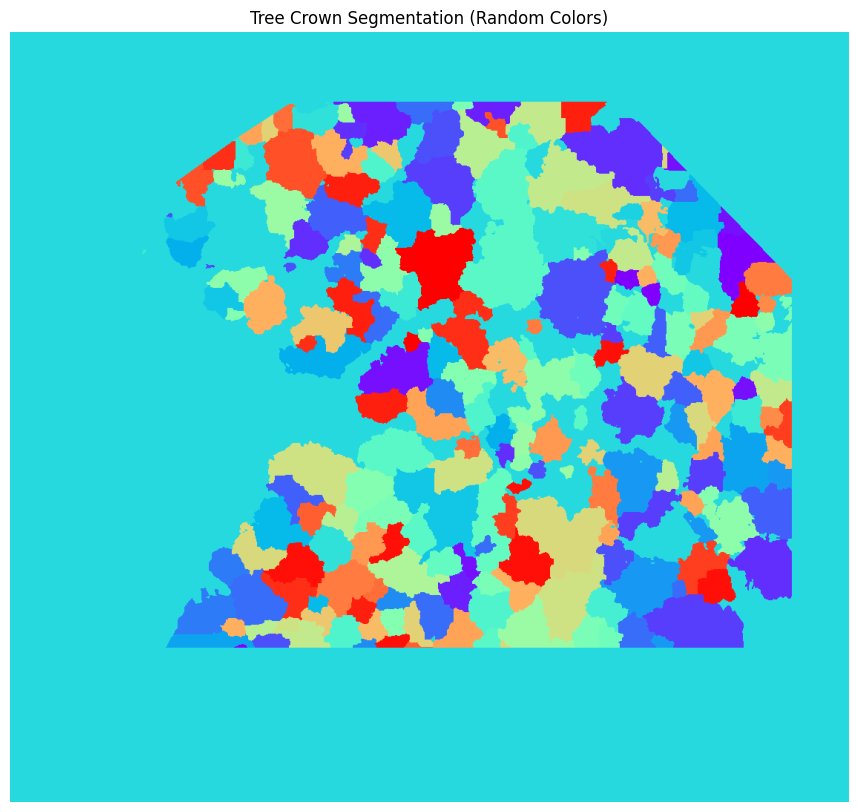

In [ ]:
# Generate random color map
num_segments = crown_segments.max()
colors = np.random.choice(range(50), size=num_segments + 1, replace=True)

# Display with random colors
plt.figure(figsize=(12, 10))
plt.imshow(colors[crown_segments], cmap='rainbow')
plt.title("Tree Crown Segmentation (Random Colors)")
plt.axis('off')
plt.show()


#### Draw Polygons

In [ ]:


# Collect crown polygons
polygons = []
ids = []

for region_id in np.unique(crown_segments):
    if region_id == 0:
        continue  # skip background

    # Extract mask for this crown
    mask = crown_segments == region_id

    # Get contours around the crown
    contours = find_contours(mask.astype(np.uint8), 0.5)

    for contour in contours:
        # Convert row/col to real-world coordinates
        rows, cols = contour[:, 0], contour[:, 1]
        xs = chm.x[cols.astype(int)]
        ys = chm.y[rows.astype(int)]

        # Create polygon
        coords = list(zip(xs, ys))
        if len(coords) >= 3:  # must be a valid polygon
            poly = Polygon(coords)
            polygons.append(poly)
            ids.append(region_id)


#### Create GeoDataFrame

In [ ]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame({'id': ids}, geometry=polygons, crs=chm.rio.crs)


#### Save to Shapefile or GeoJSON

In [ ]:
gdf.to_file("tree_crowns.shp")

#### Visualize Crowns Over CHM

ValueError: x and y must be the same size

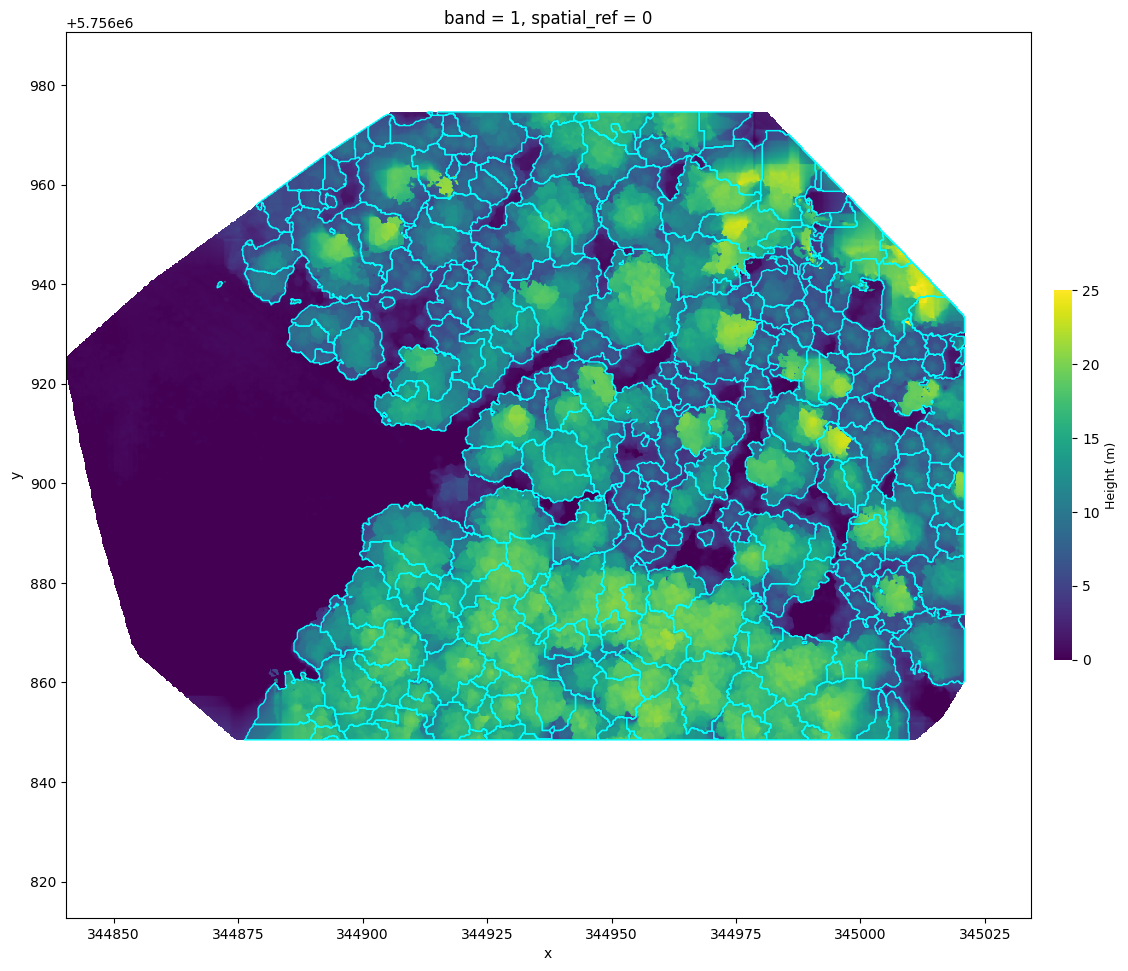

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 12))
ax = plt.gca()

# Plot CHM in viridis without default colorbar
im = chm.plot(
    ax=ax,
    cmap='viridis',
    vmin=0, vmax=25,
    add_colorbar=False
)

# Add manual colorbar
cbar = ax.figure.colorbar(
    im, ax=ax,
    orientation='vertical',
    shrink=0.4,
    aspect=20,
    pad=0.02,
    extend='neither'
)
cbar.set_label('Height (m)', fontsize=9)

# Remove colorbar frame
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

# Plot crown polygon boundaries
gdf.boundary.plot(ax=ax, color='cyan', linewidth=1.0)

# Tree tops as magenta dots
plt.scatter(x_coords, y_coords, color='magenta', s=8, label='Tree Tops')

# Create custom legend handles
legend_handles = [
    mpatches.Patch(color='cyan', label='Tree Crowns'),
    mpatches.Patch(color='magenta', label='Tree Tops')
]

# Remove axes
ax.set_axis_off()
plt.title("Tree Crowns & Tree Tops on CHM", fontsize=14)

# Show legend
plt.legend(handles=legend_handles, loc='upper right')

# Add 10m black scale bar
x0 = chm.x.min() + 10
y0 = chm.y.min() + 10
x1 = x0 + 10
ax.plot([x0, x1], [y0, y0], color='black', linewidth=2)
ax.text((x0 + x1) / 2, y0 - 5, '10 m', color='black',
        ha='center', va='top', fontsize=9)

plt.show()

In [ ]:

# Export stats for each polygon based on CHM raster
stats = zonal_stats(
    vectors=gdf.geometry,
    raster=chm.values,         # 2D numpy array of CHM
    affine=chm.rio.transform(),  # GeoTransform of the CHM
    stats=['mean', 'count', 'min', 'max'],
    nodata=chm.rio.nodata
)


NameError: name 'zonal_stats' is not defined

### Collect Tree Data

In [ ]:
# Convert list of stats dicts to DataFrame and merge
import pandas as pd

stats_df = pd.DataFrame(stats)
gdf = gdf.join(stats_df)

# Calculate area in m²
gdf["area_m2"] = gdf.geometry.area

# Rename mean height column for clarity
gdf = gdf.rename(columns={"mean": "mean_height_m"})

gdf


id                                           geometry mean_height_m  \
0      1  POLYGON ((344968.313 5756951.861, 344968.172 5...          None   
1      2  POLYGON ((344979.895 5756957.228, 344979.754 5...          None   
2      3  POLYGON ((344992.748 5756938.585, 344992.606 5...          None   
3      3  POLYGON ((344987.804 5756947.765, 344987.804 5...          None   
4      3  POLYGON ((344989.358 5756946.918, 344989.358 5...          None   
..   ...                                                ...           ...   
608  528  POLYGON ((345076.784 5756902.145, 345076.643 5...          None   
609  529  POLYGON ((345048.254 5756870.225, 345048.113 5...          None   
610  530  POLYGON ((344916.479 5756896.213, 344916.338 5...          None   
611  531  POLYGON ((345048.254 5756851.017, 345048.113 5...          None   
612  532  POLYGON ((345074.948 5756934.63, 345074.807 57...          None   

     count   min   max     area_m2  
0        0  None  None  121.564864  
1        0  None  None   38.659781  
2        0  None  None   97.267850  
3        0  None  None    0.069819  
4        0  None  None    0.079793  
..     ...   ...   ...         ...  
608      0  None  None    4.528261  
609      0  None  None    2.164389  
610      0  None  None    6.912082  
611      0  None  None    2.274105  
612      0  None  None    0.009974  

[613 rows x 7 columns]